In [2]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage
import time

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\"

#model = load_model(path + 'models/' + 'EDGEnet2_round_L1_epoch_4.h5')
model = load_model(path + 'LER_machine_learning\\models\\' + 'EDGEnet2_round_L1_epoch_4.h5')
#model.summary()

In [21]:
np.random.seed(21)
sigma = 1.6
alpha = 0.6
Xi = 30
width = 20
space = 40
noise = 100
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

#original_file = path + 'original_images2/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
#noisy_file = path + 'noisy_images2/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

original_file = path + 'original_images2\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images2\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'


imnoisy = np.array(Image.open(noisy_file))
im = np.array(Image.open(original_file))

imnoisy = (imnoisy)/256
imnoisy = imnoisy + np.random.normal(0, 0.1 * (256/255), imnoisy.shape)



imnoisy = imnoisy.reshape(1,1024,64,1)

start = time.time()
linepredict = model.predict(imnoisy)
prediction_time = time.time() - start

print(prediction_time)

imnoisy = imnoisy.reshape(1024,64)
linepredict = linepredict.reshape(1024,2)
print(linepredict.shape)

8.391189098358154
(1024, 2)


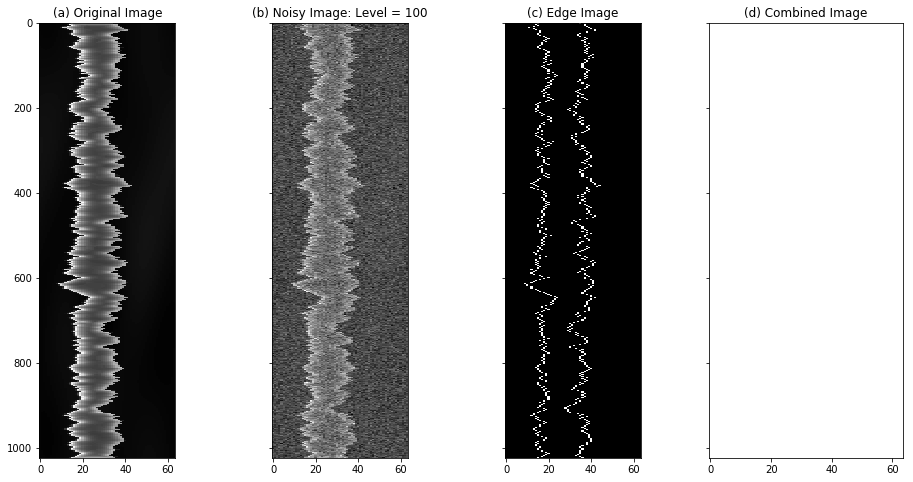

In [22]:

%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(im,cmap = 'gray',aspect= 0.2)
ax[0].set_title('(a) Original Image')

ax[1].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[1].set_title('(b) Noisy Image: Level = {}'.format(noise))

edgepredict = np.zeros((1024,64))
i =[]
for i in range(1024):
    edgepredict[i, (linepredict*64).round().astype(int)[i,0]] = 1
    edgepredict[i, (linepredict*64).round().astype(int)[i,1]] = 1
    
ax[2].imshow(edgepredict, cmap = 'gray',aspect= 0.2)
ax[2].set_title('(c) Edge Image')

combine = np.zeros((1024,64,3))
combine[:,:,0] = imnoisy
combine[:,:,1] = edgepredict

#ax[3].imshow(combine, cmap = 'gray', aspect= 0.2)
ax[3].set_title('(d) Combined Image')

plt.show()


Original leftline sigma = 1.2234912495115058, rightline sigma = 1.4199944101143003
Predicted leftline sigma = 1.224753737449646, rightline sigma = 1.408539891242981
31.0
88.0
Mean absolute position error = 0.05810546875
Original LWR = 1.9169958564462788 
Predicted LWR = 1.9067462682724 
LWR_accuracy = 99.4653307079714
Left_LER_accuracy = 99.89681267122717
Right_LER_accuracy = 99.19334056600988


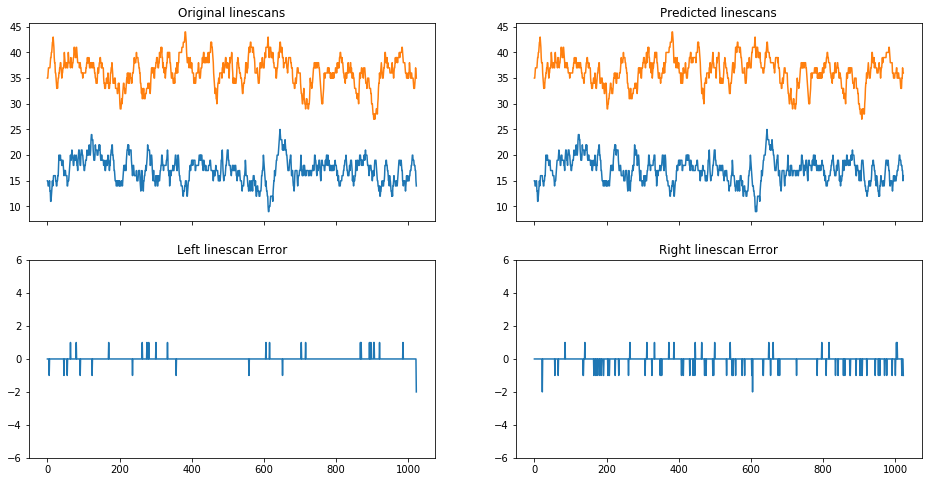

In [23]:
#linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'

linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

Original_left_LER = leftline.round().std()/2
Original_right_LER = rightline.round().std()/2
Predicted_left_LER = (linepredict*64).round()[:,0].std()/2
Predicted_right_LER = (linepredict*64).round()[:,1].std()/2
print('Original leftline sigma = {}, rightline sigma = {}'.format(Original_left_LER, Original_right_LER))
print('Predicted leftline sigma = {}, rightline sigma = {}'.format(Predicted_left_LER, Predicted_right_LER))

left_error = np.abs(leftline.round() - (linepredict*64).round()[:,0]).sum()
right_error = np.abs(rightline.round() - (linepredict*64).round()[:,1]).sum()
print(left_error)
print(right_error)
print('Mean absolute position error = {}'.format((left_error + right_error)/2048))

Original_LWR = (rightline.round() - leftline.round()).std()/2
Predicted_LWR = ((linepredict*64).round()[:,0] - (linepredict*64).round()[:,1]).std()/2

print('Original LWR = {} '.format(Original_LWR))
print('Predicted LWR = {} '.format(Predicted_LWR))
print('LWR_accuracy = {}'.format(100 - (100*np.abs(Predicted_LWR - Original_LWR)/Original_LWR)))
print('Left_LER_accuracy = {}'.format(100 - (100*np.abs(Predicted_left_LER - Original_left_LER)/Original_left_LER)))
print('Right_LER_accuracy = {}'.format(100 - (100*np.abs(Predicted_right_LER - Original_right_LER)/Original_right_LER)))

ax[0,0].plot(leftline.round())
ax[0,0].plot(rightline.round())
ax[0,0].set_title('Original linescans')

ax[0,1].plot((linepredict*64).round())
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.round() - (linepredict*64).round()[:,0])
ax[1,0].set_title('Left linescan Error')
ax[1,0].set_ylim([-6,6])

ax[1,1].plot(rightline.round() - (linepredict*64).round()[:,1])
ax[1,1].set_title('Right linescan Error')
ax[1,1].set_ylim([-6,6])

plt.show()

Left Bias:  309.45299060001304
Right Bias:  332.4792294126411
Left distance:  14.89595581975067
Right distance:  29.515211019355213


c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\spectrum-0.7.3-py3.5-win-amd64.egg\spectrum\mtm.py:529: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\spectrum-0.7.3-py3.5-win-amd64.egg\spectrum\mtm.py:530: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

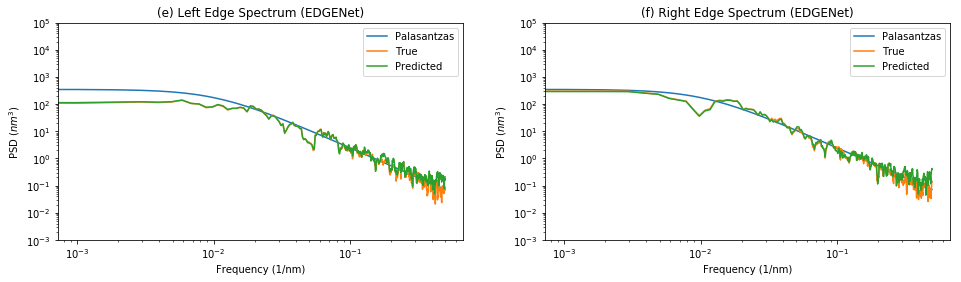

In [24]:
from spectrum import pmtm

# Spectrum analysis code by Sai
NFFT_VAL = 1024
range_psd = int(NFFT_VAL/2)

#leftmean = leftline.mean()
#rightmean = rightline.mean()
leftmean = 30 + shift                     # Change the mean to zero
rightmean = 30 + shift + width            # Change the mean to zero

leftline_spec = leftline - leftmean
rightline_spec = rightline - rightmean

#leftpred_spec = (linepredict*64).round()[:,0] - (linepredict*64).round()[:,0].mean()
#rightpred_spec = (linepredict*64).round()[:,1] - (linepredict*64).round()[:,1].mean()

leftpred_spec = (linepredict*64).round()[:,0] - leftmean
rightpred_spec = (linepredict*64).round()[:,1] - rightmean

left_multitape_spectrum = pmtm(leftline_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
left_Sk = abs(left_multitape_spectrum[0])**2
left_Sk = np.mean(left_Sk * np.transpose(left_multitape_spectrum[1]), axis = 0)
left_Sk = np.fft.fftshift(left_Sk)

right_multitape_spectrum = pmtm(rightline_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
right_Sk = abs(right_multitape_spectrum[0])**2
right_Sk = np.mean(right_Sk * np.transpose(right_multitape_spectrum[1]), axis = 0)
right_Sk = np.fft.fftshift(right_Sk)

left_multitape_spectrum_predict = pmtm(leftpred_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
left_Sk_predict = abs(left_multitape_spectrum_predict[0])**2
left_Sk_predict = np.mean(left_Sk_predict * np.transpose(left_multitape_spectrum_predict[1]), axis = 0)
left_Sk_predict = np.fft.fftshift(left_Sk_predict)

right_multitape_spectrum_predict = pmtm(rightpred_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
right_Sk_predict = abs(right_multitape_spectrum_predict[0])**2
right_Sk_predict = np.mean(right_Sk_predict * np.transpose(right_multitape_spectrum_predict[1]), axis = 0)
right_Sk_predict = np.fft.fftshift(right_Sk_predict)


left_bias = np.sum(np.abs((left_Sk_predict[512:] - left_Sk[512:])/left_Sk[512:]))
right_bias = np.sum(np.abs((right_Sk_predict[512:] - right_Sk[512:])/right_Sk[512:]))

print('Left Bias: ', left_bias)
print('Right Bias: ', right_bias)

left_distance = np.linalg.norm(left_Sk_predict[512:] - left_Sk[512:])
right_distance = np.linalg.norm(right_Sk_predict[512:] - right_Sk[512:])


print('Left distance: ', left_distance)
print('Right distance: ', right_distance)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

#x_axis = np.arange(512)/1024

N, L = 1024, 2048*1e-09
freq = np.zeros(1024)
for i in range(N):
    freq[i] = i - (N/2)
freq = 2*np.pi*freq/L

num = (np.sqrt(np.pi))*(math.gamma(alpha + 0.5)/math.gamma(alpha))*(2*(Xi*1e-09)*(sigma*1e-09)**2)
denom = (1 +(freq*Xi*1e-09)**2)**(alpha + 0.5)

PSD = num/denom


x_axis = freq[512:]*1e-09/(np.pi)

ax[0].plot(x_axis,1e27 * PSD[512:] * (L*1e09)/N, label = 'Palasantzas')
ax[0].plot(x_axis,left_Sk[512:], label = 'True')
ax[0].plot(x_axis,left_Sk_predict[512:], label = 'Predicted')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency (1/nm)')
ax[0].set_ylabel('PSD ($nm^3$)')
ax[0].set_title('(e) Left Edge Spectrum (EDGENet)')
ax[0].legend()
ax[0].set_ylim(0.001, 100000)
#ax[0].axvline(x=1/(2*np.pi*Xi))

ax[1].plot(x_axis,1e27 * PSD[512:] * (L*1e09)/N, label = 'Palasantzas')
ax[1].plot(x_axis,right_Sk[512:], label = 'True')
ax[1].plot(x_axis,right_Sk_predict[512:], label = 'Predicted')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (1/nm)')
ax[1].set_ylabel('PSD ($nm^3$)')
ax[1].set_title('(f) Right Edge Spectrum (EDGENet)')
ax[1].legend()
ax[1].set_ylim(0.001, 100000)
#ax[1].axvline(x=1/(2*np.pi*Xi))

plt.show()

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


7.927023012470222e-10
1.9531250000000002


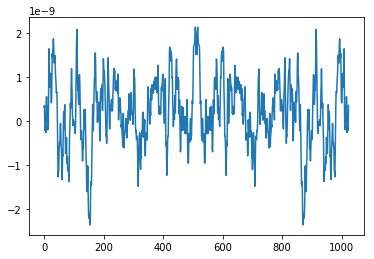

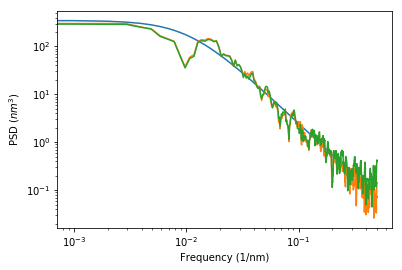

In [25]:


FFT_edge = np.zeros(N);
j = 0
while j < (N//2):
        if(j == 0):
            FFT_edge[j + N//2] = np.sqrt(PSD[j + N//2])*np.random.normal()
        else:
            FFT_edge[j + N//2] = np.sqrt(PSD[j + N//2])*(np.random.normal() + 1j*np.random.normal())/np.sqrt(2)
        j += 1

j = 1            
while j < N//2 - 1:
    FFT_edge[j] = np.conj(FFT_edge[N - j])   #Make PSD symmetric because edge is real  
    j += 1 

FFT_edge[0] = np.sqrt(PSD[0])*np.random.normal()

e = np.fft.ifft(np.fft.fftshift((N/np.sqrt(L))*FFT_edge))
print(e.std())
print((L/N**2) * 1e12)
plt.plot(e)
plt.show()

e_FFT = np.abs(np.fft.fftshift(np.fft.fft(e)))


#plot2, = plt.plot(freq[512:]*1e-09/(np.pi), 1e27 * np.abs(FFT_edge)[512:]**2)
plot1, = plt.plot(freq[512:]*1e-09/(np.pi), 1e27 * PSD[512:] * (L*1e09)/N)
#plt.plot(freq[512:]*1e-09/(np.pi), L/(N**2) * 1e27 * e_FFT[512:]**2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (1/nm)')
plt.ylabel('PSD ($nm^3$)')
plt.plot(freq[512:]*1e-09/(np.pi), right_Sk[512:])
plt.plot(x_axis, right_Sk_predict[512:])

#plt.legend([plot1,plot2],["Palasantzas PSD", "Random PSD"])

plt.show()

In [26]:

PSD_0 = PSD[512] * 1e27 * (L*1e09)/N
right_PSD_0 = right_Sk[512]
print(np.sqrt(PSD_0/((2*alpha + 1)*Xi)))
print(np.sqrt(right_PSD_0/((2*alpha + 1)*Xi)))

#print(1/(2*np.pi*Xi))

2.295731321647055
2.0543057856497358


In [27]:
# Code for reading logfile
"""
logfile = path + 'LER_machine_learning\\neural_nets\\EDGEnet2_round_L1_epoch4.748390'
losses = []
with open(logfile,'r') as f:
    for line in f:
        if 'loss' in line:
            losses.append(float(line.split()[-1]))
plt.plot(losses)
plt.ylabel('MAE Loss')
plt.xlabel('Step number')
plt.title('Training set loss (logscale)')
plt.yscale('log')
plt.savefig(path + 'Training_loss.png')
"""

"\nlogfile = path + 'LER_machine_learning\\neural_nets\\EDGEnet2_round_L1_epoch4.748390'\nlosses = []\nwith open(logfile,'r') as f:\n    for line in f:\n        if 'loss' in line:\n            losses.append(float(line.split()[-1]))\nplt.plot(losses)\nplt.ylabel('MAE Loss')\nplt.xlabel('Step number')\nplt.title('Training set loss (logscale)')\nplt.yscale('log')\nplt.savefig(path + 'Training_loss.png')\n"